### Introduction

Colorization is the process of coloring monochrome images. 
It has been widely used in photo processing and scientific illustration.  
Colorization process is tedious, time consuming and requires artistic skills to precisely add the appropriate colors to the image.
People colorize historical black and white images manually using Photoshop which is a tedious job.
We have proposed a way to effectively colorize images with significantly reduced amount of user efforts.
 
 



#### The Problem

Main objective of image colorization is converted gray scale image (black and white) to color image using CNN.

In recent years, CNNs have emerged as the standard for solving image classification problems, achieving error rates lower than 4% in the ImageNet challenge.

CNNs owe much of their success to their ability to learn and discern colors, patterns, and shapes within images and associate them with object classes.

#### The Data

For this project, we'll use a subset of the [MIT Places](http://places.csail.mit.edu/) dataset of places, landscapes, and buildings. 

In [ ]:
# Download and unzip (2.2GB)
!wget http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
!tar -xzf testSetPlaces205_resize.tar.gz

--2021-05-24 08:47:20--  http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2341250899 (2.2G) [application/octet-stream]
Saving to: ‘testSetPlaces205_resize.tar.gz’

s205_resize.tar.gz    8%[>                   ] 193.84M  1006KB/s    eta 36m 19s^C

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [ ]:
# Move data into training and validation directories
import os
os.makedirs('images/train/class/', exist_ok=True) # 40,000 images
os.makedirs('images/val/class/', exist_ok=True)   #  1,000 images
for i, file in enumerate(os.listdir('testSet_resize')):
  if i < 1000: # first 1000 will be val
    os.rename('testSet_resize/' + file, 'images/val/class/' + file)
  else: # others will be val
    os.rename('testSet_resize/' + file, 'images/train/class/' + file)

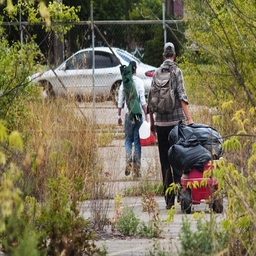

In [ ]:
# Make sure the images are there
from IPython.display import Image, display
display(Image(filename='/content/images/val/class/00c1684a77912fdbd7e08dd78af9b849.jpg'))

#### The Tools

We'll build and train our model with PyTorch. We'll also use torchvision, a helpful set of tools for working with images and videos in PyTorch, and scikit-learn for converting between RGB and LAB colorspces. 


In [ ]:
# Download and import libraries
!pip install torch torchvision matplotlib numpy scikit-image pillow==4.1.1

     |████████████████████████████████| 11.3MB 263kB/s 
     |████████████████████████████████| 112kB 48.8MB/s 
  Created wheel for pillow: filename=Pillow-4.1.1-cp37-cp37m-linux_x86_64.whl size=1009690 sha256=5670f17c1d1306bc95b54c3afe19d6d0eb15da6eacb175151ae40d1e606540c2
  Stored in directory: /root/.cache/pip/wheels/3f/f3/3e/f24b51fe136968f797933559011acd48b16708fc306c924770
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35416 sha256=e14648e4285915fb126d7f4e7941fcd5e90db671dd4a23116e573d979a47dd28
  Stored in directory: /root/.cache/pip/wheels/4b/f4/11/bc4166107c27f07fd7bba707ffcb439619197638a1ac986df3
Successfully built pillow olefile
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.1.1 which is incompatible.
ERROR: bokeh 2.3.2 has requirement pillow>=7.1.0, but you'll have pillow 4.1.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incom

In [ ]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time

In [ ]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()


### The Model

Our model is a convolutional neural network. We first apply a number of convolutional layers to extract features from our image, and then we apply deconvolutional layers to upscale (increase the spacial resolution) of our features.  

Specifically, the beginning of our model will be ResNet-18, an image classification network with 18 layers and residual connections. We will modify the first layer of the network so that it accepts grayscale input rather than colored input, and we will cut it off after the 6th set of layers. 

![model](https://raw.githubusercontent.com/lukemelas/lukemelas.github.io-src/master/content/assets/images/colorization/model.jpg)

Now, we'll define our model in code. We'll start with the second half of the net, the upsampling layers:

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

Now let's create our model and load it onto the GPU.

In [ ]:
model = ColorizationNet()

### Training

#### Loss Function

Since we are doing regression, we'll use a mean squared error loss function: we minimize the squared distance between the color value we try to predict, and the true (ground-truth) color value.  

In [ ]:
criterion = nn.MSELoss()

This loss function is slightly problematic for colorization due to the multi-modality of the problem. 
  



#### Optimizer

We will optimize our loss function (criterion) with the Adam optimizer. 

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

#### Loading the data

We'll use torchtext to load the data. Since we want images in the LAB space, we first have to define a custom dataloader to convert the images.

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

Next we define transforms for our training and validation data.

In [ ]:
# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('images/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('images/val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

#### Helper functions

Before we train, we define helper functions for tracking the training loss and converting images back to RGB. 

In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

#### Validation

In validation, we simply run model without backpropagation using `torch.no_grad`. 

In [ ]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

#### Training

In training, run model and backpropagate using `loss.backward()`. We first define a function that trains for one epoch: 

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

Next, we define a training loop and we train for 50 epochs:

In [ ]:
# Move model and loss function to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [ ]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 50

In [ ]:
# Train model
for epoch in range(epochs):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

Starting training epoch 0
Epoch: [0][0/625]	Time 1.375 (1.375)	Data 1.279 (1.279)	Loss 0.0034 (0.0034)	
Epoch: [0][25/625]	Time 1.332 (1.327)	Data 1.261 (1.254)	Loss 0.0027 (0.0034)	
Epoch: [0][50/625]	Time 1.303 (1.326)	Data 1.232 (1.254)	Loss 0.0038 (0.0034)	
Epoch: [0][75/625]	Time 1.303 (1.320)	Data 1.227 (1.248)	Loss 0.0027 (0.0034)	
Epoch: [0][100/625]	Time 1.309 (1.319)	Data 1.237 (1.247)	Loss 0.0030 (0.0033)	
Epoch: [0][125/625]	Time 1.275 (1.316)	Data 1.203 (1.244)	Loss 0.0032 (0.0033)	
Epoch: [0][150/625]	Time 1.302 (1.316)	Data 1.230 (1.244)	Loss 0.0036 (0.0033)	
Epoch: [0][175/625]	Time 1.289 (1.314)	Data 1.218 (1.242)	Loss 0.0032 (0.0033)	
Epoch: [0][200/625]	Time 1.325 (1.314)	Data 1.253 (1.242)	Loss 0.0036 (0.0032)	
Epoch: [0][225/625]	Time 1.300 (1.314)	Data 1.229 (1.242)	Loss 0.0031 (0.0032)	
Epoch: [0][250/625]	Time 1.279 (1.313)	Data 1.207 (1.241)	Loss 0.0028 (0.0032)	
Epoch: [0][275/625]	Time 1.301 (1.312)	Data 1.229 (1.240)	Loss 0.0030 (0.0032)	
Epoch: [0][300/625]

<Figure size 432x288 with 0 Axes>

### Results 


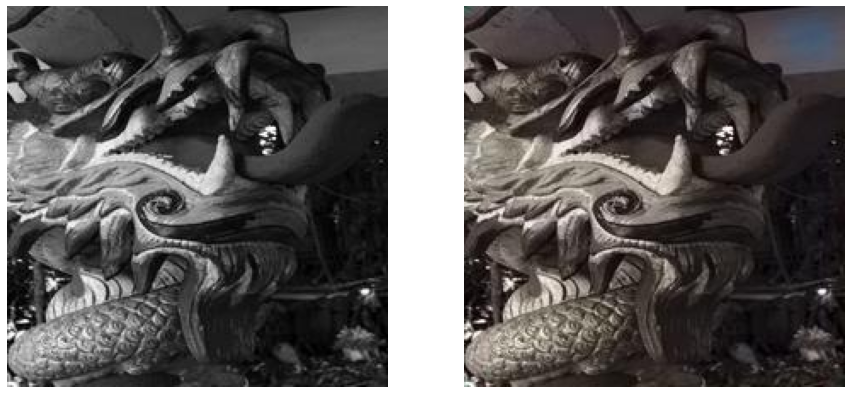

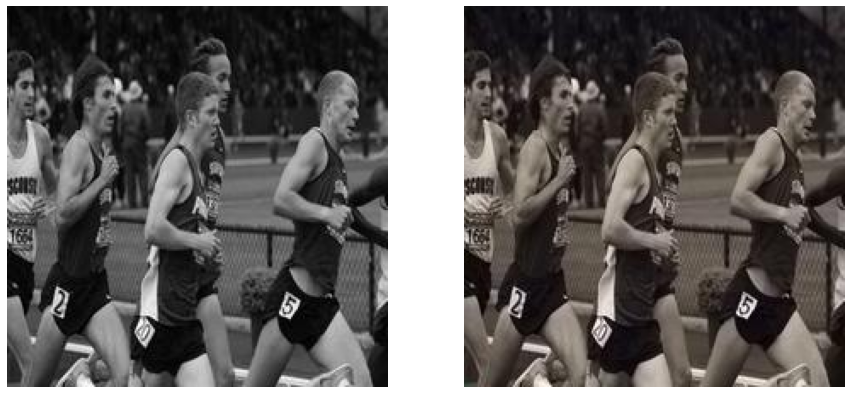

In [ ]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-2-epoch-0.jpg', 'outputs/gray/img-2-epoch-0.jpg'),
               ('outputs/color/img-7-epoch-0.jpg', 'outputs/gray/img-7-epoch-0.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()